# SmoothLife L
## Julia Version 1.0.3

In [1]:
using Images, PyPlot, PyCall
@pyimport matplotlib.cm as cm

In [44]:
function makeMask(r_out, r_in=0.0, AA=0.0; normalize=true)
    @assert(AA>=0.0, "Antialiasing border size cannot be negative!")
    mask = zeros(Float64, 2*r_out+1, 2*r_out+1)
    cen = (r_out+1, r_out+1)
    for x in -r_out:r_out
        for y in -r_out:r_out
            l = sqrt(x^2 + y^2)
            if r_in <= l < r_out + AA/2
                if l < r_out - AA/2
                    mask[x+cen[1], y+cen[2]] = 1.0
                else
                    mask[x+cen[1], y+cen[2]] = (r_out + AA/2 - l)/AA
                end
            end
        end
    end 
    
    return normalize ? mask/sum(mask) : mask
end

"""
    makeInnerMask(r_in[, AA=0.0])

Create a matrix filled with a ring of non-zero floats.
The sum of matrix is normalized to be equal to 1.0.

# Arguments
* `r_in::Int`: the inner radius of the ring. Must be smaller than r_out.
* `AA::Float64`: Thickness of antialiasing. 0.0 means no antialiasing.
"""
function makeInnerMask(r_in, AA=0.0; verbose=false)::Array{Float64,2}
    mask = makeMask(r_in, 0.0, AA)
    if verbose; plt[:figure](); plt[:axis]("off"); plt[:imshow](mask) end
    return mask
end

"""
    makeOuterMask(r_out, r_in[, AA=false])

Create a matrix filled with a ring of non-zero floats.
The sum of matrix is normalized to be equal to 1.0.

# Arguments
* `r_out::Int64`: the outer radius of the ring. Must be greater than r_in.
* `r_in::Int64`: the inner radius of the ring. Must be smaller than r_out.
* `AA`: Thickness of antialiasing. 0.0 means no antialiasing.
"""
function makeOuterMask(r_out, r_in, AA=0.0; verbose=false, subtract=false)::Array{Float64,2}
    mask = nothing
    if subtract
        mask = makeOuterMasksubtracted(r_out, r_in, AA)
    else
        mask = makeMask(r_out, r_in, AA)
    end

    if verbose; plt[:figure](); plt[:axis]("off"); plt[:imshow](mask) end
    return mask
end

"""
In this version, the inner mask is subtracted. Using antialiasing, this will lead to an continuous transition from inner to outer.
For further information, see 'makeOuterMask'.
"""
function makeOuterMasksubtracted(r_out, r_in, AA=0.0; verbose=false)::Array{Float64,2}
    mask = makeMask(r_out, 0.0, AA; normalize=false)
    
    # make the hole of the ring
    #mask_sub = zeros(Float64, 2*r_out+1, 2*r_out+1)
    mask_in = makeMask(r_in, 0.0, AA, normalize=false)
    println(size(mask_in))
    println(size(mask))
    println(size(mask[r_out-r_in+1:r_out+r_in+1, r_out-r_in+1:r_out+r_in+1]))
    flush(stdout)
    mask[r_out-r_in+1:r_out+r_in+1,r_out-r_in+1:r_out+r_in+1] -= mask_in
    
    #normalize mask, so that sum(mask) == 1.0
    mask /= sum(mask)
    
    if verbose; plt[:figure](); plt[:axis]("off"); plt[:imshow](mask) end
    return mask
end

makeOuterMasksubtracted

In [45]:
"""
Initiate grid with a splats. Can be squared or round
# Arguments
* `grid`: 
* `height`: grid height
* `width`: grid width
* `r_out`: outer radius of conv mask
* `round`: if true, make round splats. Make squares otherwise
"""
function splat!(grid::Array{Float64,2}, height, width, r_out; round=true)
	x = floor(Int64, rand()*width)+1
	y = floor(Int64, rand()*height)+1
	c = max(0.5, rand()) # val ∈ [0.5, 1.0]

    for dx in -r_out:r_out
        for dy in -r_out:r_out
            # make a splat around [ix, iy]
            ix = x+dx
            iy = y+dy
            if 1<=ix<=width && 1<=iy<=height && (!round || round && sqrt(dx^2+dy^2) <= r_out)
                grid[ix,iy] = c
            end
        end
    end
    
    return grid
end

"""
Return a grid initiated with splats.
    
# Arguments
* `height`: grid height
* `width`: grid width
* `r_out`: outer radius of conv mask
"""
function initGrid(height, width, r_out)::Array{Float64,2}
	grid = zeros(Float64, height,width)
	for t in 0:((width/r_out)*(height/r_out))
		splat!(grid, height, width, r_out)
	end
    return grid
end

initGrid

In [46]:
#=
#Hack: in the paper, λ is different for n and m! The smoothness allows us to use smaller masks for similar precision
function σ1(x::Float64, a::Float64)
    return 1.0 ./ (1.0 + exp(-4.0.*(x-a))) 
end

function σ2(x::Float64, a::Float64, b::Float64)
    return σ1(x,a).*(1.0 - σ1(x,b))
end

function σm(x::Float64, y::Float64, m::Float64)
    return x.*(1.0 - σ1(m, 0.5)) + y.*σ1(m, 0.5)
end

"""
Evaluate inner and outer filling of a cell. The used formulars and constants were proposed for smooth, stable gliders.
These can be found in the original smoothlife paper from 2011.

The function is a mapping of [0,1) x [0,1) ⟶ [0,1).

#Arguments
* `n::Float64`: outer filling ∈ [0,1]
* `m::Float64`: inner filling ∈ [0,1]
"""
function s(n::Float64, m::Float64)
    #Note: birth interval [b1,b2] and death interval [d1, d2]. Values based on original paper
    const b1 = 0.278
    const b2 = 0.365
    const d1 = 0.267
    const d2 = 0.445
    return σ2(n, σm(b1,d1,m), σm(b2,d2,m))
end

"""
smoothed integral step into the next generation.
    f(x, t + dt) = f(x) + dt * (2*s(n,m)-1) * f(x)

#Arguments
* `f::Float64`: value of the current cell (x,y) with f = f(x,y), n = mask_outer(x,y) , m = mask_inner(x,y)
* `n::Float64`: outer filling ∈ [0,1)
* `m::Float64`: inner filling ∈ [0,1)
* `dt::Float64`: distance in time
"""
function smoothStep(f::Float64, n::Float64, m::Float64, dt::Float64)
    #return f + dt*(2*s(n,m)-1)
    return f + dt*(2*snm(n,m)-1)
end

function smoothStep(f::Float64, n::Float64, m::Float64)
    return s(n,m)*f
end

# alternative solution
sigmoid_a(x, a, b) =  1 ./(1+exp(-4(x-a)/b))

sigmoid_b(x, b, eb) = 1 - sigmoid_a(x, b, eb)

sigmoid_ab(x, a, b, ea, eb) = sigmoid_a(x, a, ea) .* sigmoid_b(x, b, eb)

function sigmoid_mix(x, y, m, em)
    return x.*(1-sigmoid_a(m, 0.5, em)) + y.*sigmoid_a(m, 0.5, em)
end

function snm(n, m)
    const b1 = 0.278
    const b2 = 0.365
    const d1 = 0.267
    const d2 = 0.445
    const alphan = 0.028
    const alpham = 0.147
    return sigmoid_ab(n, sigmoid_mix(b1, d1, m, alpham), sigmoid_mix(b2, d2, m, alpham), alphan, alphan)
end
=#

In [47]:
function sigma1(x::Float64, a::Float64, alpha::Float64)::Float64
    return 1.0 / ( 1.0 + exp(-(x-a)*4.0/alpha));
end

"""
Corrected rules according to ref. implementation
"""
function sigma2(x::Float64, a::Float64, b::Float64)::Float64
    αn = 0.028
    return sigma1(x,a,αn) * ( 1.0 - sigma1(x,b,αn));
end

function sigmam(x::Float64, y::Float64, m::Float64)::Float64
    αm = 0.147
    return x * ( 1.0 - sigma1(m,0.5,αm)) + y*sigma1(m, 0.5, αm);
end

"""
Return the new filling based of the area of the `outer` and the `inner` ring.
"""
function discrete_step(outer::Float64, inner::Float64)::Float64
    b1 = 0.278
    b2 = 0.365
    d1 = 0.267
    d2 = 0.445

    return sigmam(sigma2(outer,b1,b2), sigma2(outer,d1,d2),inner);
end

function discrete_as_euler(outer::Float64, inner::Float64)::Float64
    return 2.0 * discrete_step(outer, inner) - 1.0;
end

function next_step_as_euler(f::Float64, outer::Float64, inner::Float64, dt::Float64)::Float64
    return f + dt * discrete_as_euler(outer,inner);
end

next_step_as_euler (generic function with 1 method)

In [48]:
"""
Create two grids. Either empty or randomized. Randomized version uses splats.
Return a tuple. The first entry is a new grid, the second is an uninitialized, 2d array of the same size (for swapping)

Splats will be of size `r_out`.
"""
function createGrid(width=100, height=100, splat=true; r_out=21)::Tuple{Array{Float64,2}, Array{Float64,2}}
    if splat
        return (initGrid(height, width, r_out), Array{Float64, 2}(undef, width, height))
    else
        return (zeros(Float64, width, height), Array{Float64,2}(undef, width, height))
    end
end

createGrid

In [51]:
"""
Start the smoothlife simulation. All results are estimates. Smaller time steps and greater masks improve resolution
but increase computation time also.
Return a 2D float matrix which represents the last state of the environment, i.e. the grid at t(runs).

#Arguments
* `runs`: The number of total iterations (convolutions)
* `start_grid`: A 2D matrix of type Float64, usually the result of a previous simulate() run.
    If supplied, the simulation will start from this matrix.
    Values must be within the interval [0.0, 1.0].
* `grid_width`:
* `grid_height`:
* `r_in::Int64`: Size of the inner ring. Greater radius takes more computation time, but improves precision.
* `r_out::Int64`: Size of outer ring. Greater radius takes more computation time, but improves precision/stability. Must be greater than radius_inner. Use 3*radius_inner for best results.
* `dt`: delta time. How much the time passes between two calculations. The greater, the rougher the estimation.
* `sleepTime`: Number of seconds the cpu waits after one complete convolution
* `showOnConsole`: if true, output grid in a python frame. Updates the same frame (video functionality)
* `verbose`: additional information output (e.g. masks)
"""
function simulate(
        ;
        runs = 10,
        start_grid = nothing,
        grid_width = 512,
        grid_height = 512,
        r_in = 9,
        r_out = 3*r_in,
        dt = 0.05,
        sleepTime = 0.1,
        showOnConsole = true,
        verbose = false
    )::Array{Float64,2}

    if start_grid == nothing
        # create a new grid with randomly positioned dots
        (curGrid, newGrid) = createGrid(grid_width, grid_height; r_out=r_out)
    else
        # continue from some other given grid
        (curGrid, newGrid) = (start_grid, zeros(Float64, grid_width, grid_height))
    end
    mask_in = makeInnerMask(r_in, 1.0; verbose=verbose)
    mask_out = makeOuterMask(r_out, r_in, 1.0; subtract=true, verbose=verbose)

    plt[:axis]("off")
    im = plt[:imshow](curGrid, cmap=cm.Greys_r, vmin = 0.0, vmax = 1.0)

    for run in 1:runs
        # convolution -> get fillings
        #imfilter_fft
        convInner = imfilter(curGrid, mask_in, "circular")  # HACK: fft is faster for masks greater 20x20
        convOuter = imfilter(curGrid, mask_out, "circular")
        
        # calc new frame
        newGrid = zeros(Float64, grid_width, grid_height) # just for debugging.
        for x in 1:grid_width
            for y in 1:grid_height
                #newGrid[x,y] = smoothStep(curGrid[x,y], convOuter[x,y], convInner[x,y], dt)
                newGrid[x,y] = max(0.0, min(1.0, next_step_as_euler(curGrid[x,y], convOuter[x,y], convInner[x,y], dt)))
            end
        end

        # swap
        curGrid = newGrid
        #newGrid = zeros(Float64, grid_width, grid_height) 

        if showOnConsole
            im[:set_data](curGrid)
            plt[:draw]()
            sleep(sleepTime)
        else
            plt[:figure](); plt[:axis]("off"); plt[:imshow](curGrid, cmap=cm.Greys_r, vmin = 0.0, vmax = 1.0)
        end
    end
    
    return curGrid;
end

simulate

(19, 19)
(55, 55)
(19, 19)


┌ Warning: assuming that the origin is at the center of the kernel; to avoid this warning, call `centered(kernel)` or use an OffsetArray
│   caller = kernelshift at imfilter.jl:1509 [inlined]
└ @ Core /home/xentrics/.julia/packages/ImageFiltering/BhPHR/src/imfilter.jl:1509


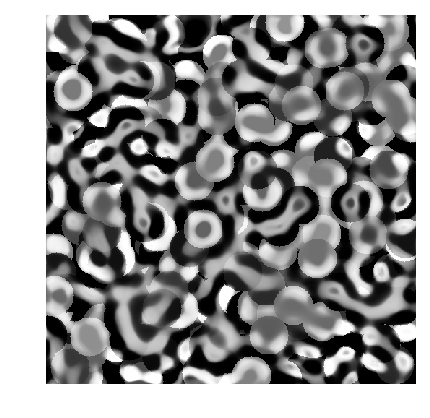

In [52]:
res = simulate(runs=30);